# Análisis y Preprocesamiento de Series Temporales de Datos de Viento

## Introducción

El conjunto de datos consiste en tres series temporales de datos observacionales de viento en tres puntos de España: Jara, Peñaparda y Miñón. Los datos que se obtienen son la velocidad y dirección del viento en estas tres localizaciones en diferentes rangos de tiempo:

- **Jara**: del 02/03/2002 al 30/06/2013
- **Peñaparda**: del 23/11/1995 al 17/02/2013
- **Miñón**: del 15/01/2002 al 29/10/2012

## Resumen Notebook `EDA-prepro.ipynb`

En el archivo `EDA-prepro.ipynb` se realiza un análisis exploratorio de los datos (EDA) y un primer preprocesamiento. Sin embargo, el código de este notebook no es reproducible ya que utiliza funciones de un proyecto mayor y datos de un conjunto de datos muy pesado. El objetivo de este notebook es explicar y reproducir el proceso de preprocesamiento de los datos. Este proceso incluye los siguientes pasos:

1. **Transformación de los datos**:
   - En vez de trabajar con la velocidad y la dirección del viento, utilizaremos sus componentes u y v (vectores x e y)

2. **Imputación de Datos Faltantes**: 
   - Los datos contienen un alto porcentaje de datos faltantes:
     - Peñaparda: 10%
     - Jara: 6.7%
     - Miñón: 2.8%
   - Estos datos se imputan utilizando datos de reanálisis (datos generados por un modelo físico a partir de observaciones).
   - Se comprueba la correlación de los datos observados con los de reanálisis para justificar su uso.

3. **Extracción de Anomalías Diarias**:
   - Se extraen las anomalías diarias para identificar desviaciones significativas de las condiciones promedio.

4. **Estandarización de los Datos**:
   - Los datos se estandarizan para tener una media de 0 y una desviación estándar de 1.

## Procedimiento

1. **Carga y Preprocesamiento de Datos**:
   - Se cargan los datos de las tres localizaciones desde archivos CSV.
   - Se añaden prefijos a las columnas `U` y `V` para identificar fácilmente la fuente de cada dato (por ejemplo, `U_jara` y `V_jara`).

2. **Unión de los DataFrames**:
   - Se combinan los tres DataFrames utilizando las fechas comunes. Solo se mantienen las fechas para las cuales existen datos en las tres fuentes.

3. **Imputación de Datos Faltantes**:
   - Se utilizan datos de reanálisis para imputar los valores faltantes, asegurando la consistencia y continuidad de las series temporales.

4. **Análisis de Correlación**:
   - Se analiza la correlación entre los datos observados y los datos de reanálisis para validar la imputación.

5. **Extracción de Anomalías y Estandarización**:
   - Se calculan las anomalías diarias y se estandarizan los datos para preparar los conjuntos de datos para futuros análisis y modelado.

## Introducción a la predicción

En este notebook, presentaremos el uso de varios métodos de predicción, desde una baseline sencilla (persistencia) hasta modelos del estado del arte como N-HiTS o PatchTST.


In [ ]:
#!pip install statsmodels
#!pip install tsai

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import sklearn
import os
from tsai.basics import *
from tsai.inference import load_learner
from sklearn.metrics import mean_squared_error, mean_absolute_error
os.environ["DEVICE"] = "cuda" 

## Cargar datos y otros análisis

In [4]:
jara = pd.read_csv('./data/jara_processed.csv').set_index('date')
pena = pd.read_csv('./data/pena_processed.csv').set_index('date')
minon = pd.read_csv('./data/minon_processed.csv').set_index('date')

In [5]:
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

def split_data(df, train_ratio, val_ratio, test_ratio):
    df = df.sort_index()

    train_size = int(len(df) * train_ratio)
    val_size = int(len(df) * val_ratio)
    test_size = len(df) - train_size - val_size

    train_df = df.iloc[:train_size]
    val_df = df.iloc[train_size:train_size + val_size]
    test_df = df.iloc[train_size + val_size:]

    return train_df, val_df, test_df

jara_train, jara_val, jara_test = split_data(jara, train_ratio, val_ratio, test_ratio)
pena_train, pena_val, pena_test = split_data(pena, train_ratio, val_ratio, test_ratio)
minon_train, minon_val, minon_test = split_data(minon, train_ratio, val_ratio, test_ratio)


Con las correlaciones totales y parciales podemos detectar que se mantiene una correlación alta hasta 96 horas atrás. Esto nos puede ayudar a decidir la ventana de contexto que utilicemos para entrenar los diferentes modelos.

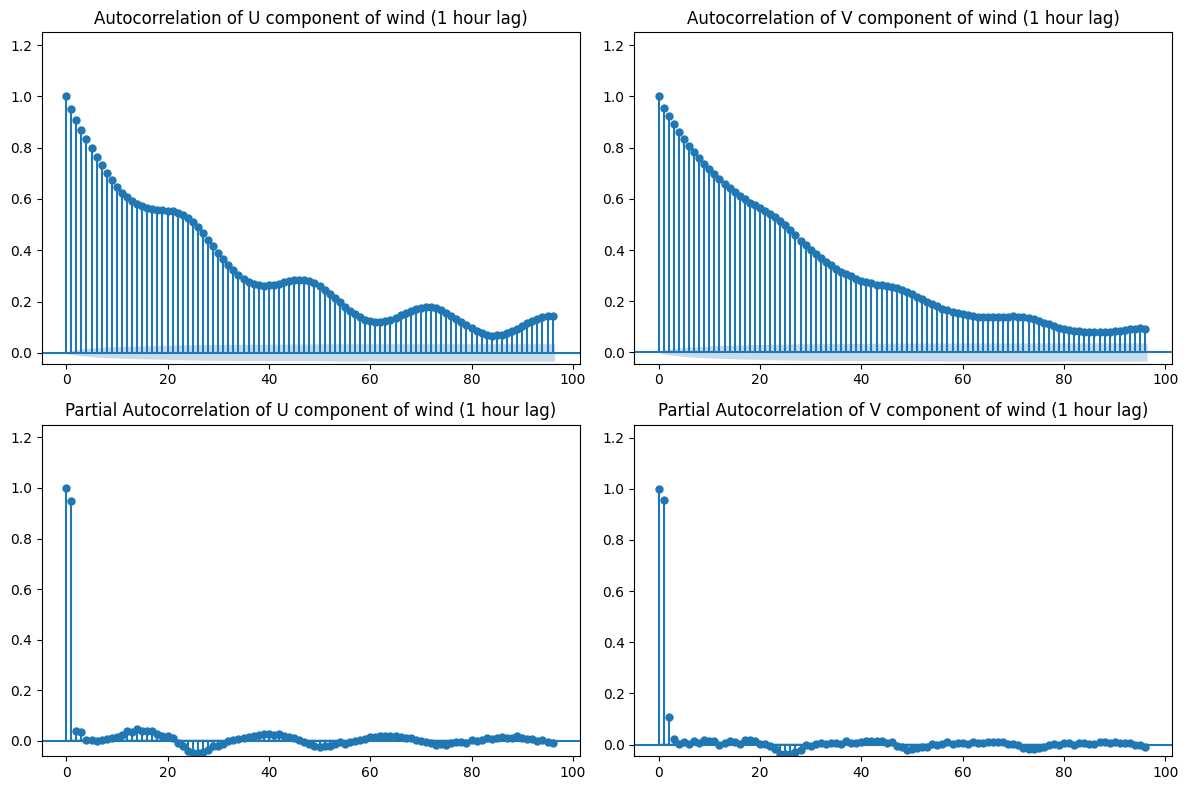

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

plot_acf(jara['U'], lags=96, auto_ylims=True, ax=axes[0, 0], title='Autocorrelation of U component of wind (1 hour lag)')
plot_acf(jara['V'], lags=96, auto_ylims=True, ax=axes[0, 1], title='Autocorrelation of V component of wind (1 hour lag)')
plot_pacf(jara['U'], lags=96, auto_ylims=True, method='ywm', ax=axes[1, 0], title='Partial Autocorrelation of U component of wind (1 hour lag)')
plot_pacf(jara['V'], lags=96, auto_ylims=True, method='ywm', ax=axes[1, 1], title='Partial Autocorrelation of V component of wind (1 hour lag)')

plt.tight_layout()
plt.show()


Como se detecta con la autocorrelación parcial, los momentos más determinantes para predecir el viento son las 2-3 horas atrás. Sin embargo, también se puede detectar una cierta tendencia a lo largo de los días.

## Baseline

Como primera baseline para comparar nuestros modelos utilizaremos persistencia sobre un horizonte de predicción de 12 h.

In [12]:
# Implementar la baseline de persistencia
def persistence_baseline(data, horizon):
    predictions = []
    true_values = []
    for i in range(len(data) - horizon):
        last_value = data.iloc[i]
        pred = [last_value] * horizon
        predictions.append(pred)
        true_values.append(data.iloc[i+1:i+horizon+1].values)
    return np.array(predictions), np.array(true_values)

# Evaluar el rendimiento de la baseline
def evaluate_performance(predictions, true_values):
    mse_scores = []
    for i in range(predictions.shape[1]):
        mse = mean_squared_error(true_values[:, i], predictions[:, i])
        mse_scores.append(mse)
    return mse_scores


In [13]:
horizon = 12

for dataset_name, dataset in [('jara', jara_test), ('pena', pena_test), ('minon', minon_test)]:
    predictions_U, true_values_U = persistence_baseline(dataset['U'], horizon)
    predictions_V, true_values_V = persistence_baseline(dataset['V'], horizon)

    mse_U = evaluate_performance(predictions_U, true_values_U)
    mse_V = evaluate_performance(predictions_V, true_values_V)

    print(f"Resultados para {dataset_name}:")
    print(f"Errores MSE para U: {np.mean(mse_U):.2f} {mse_U}")
    print(f"Errores MSE para V: {np.mean(mse_V):.2f} {mse_V}")


Resultados para jara:
Errores MSE para U: 0.47 [0.10230539285516575, 0.1890281158901961, 0.2610199478582012, 0.33260435016026174, 0.4003816471872532, 0.4643920782973107, 0.5242742475037213, 0.5813289631260284, 0.6343159427293781, 0.6816932002514274, 0.720759228455777, 0.7550545533569731]
Errores MSE para V: 0.37 [0.0967308439324283, 0.15717234183445253, 0.2115677020181572, 0.2689517813364556, 0.3119841622761421, 0.3611484717955262, 0.40929774915791134, 0.4524899587345736, 0.49177818768210796, 0.5230902679713254, 0.5553940023013346, 0.5897211787684835]
Resultados para pena:
Errores MSE para U: 1.06 [0.68228016396843, 0.7762825969151521, 0.8610405201757492, 0.9439300272355069, 1.0090357327155384, 1.0710768607146373, 1.1288533331939463, 1.1800239196752433, 1.2284642317761703, 1.250691301931634, 1.2735917494906699, 1.2929318526253242]
Errores MSE para V: 0.69 [0.296351645756906, 0.40748056708216096, 0.4839607986667687, 0.5559767961195763, 0.6230174365463129, 0.6863985901225856, 0.749042482

# PatchTST

Se presentan dos opciones de predicción. Combinar las 3 fuentes e intentar predecir las 3 (la correlación espacial podría ayudar), predecir una a una (la tarea es menos compleja)

In [16]:
# Cambiar nombres de las columnas para incluir el prefijo adecuado
jara = jara.rename(columns=lambda col: f'jara_{col}')
pena = pena.rename(columns=lambda col: f'pena_{col}')
minon = minon.rename(columns=lambda col: f'minon_{col}')

# Unir los DataFrames basados en las fechas comunes
combined_df = jara.join([pena, minon], how='inner')

# Restablecer el índice para incluir una columna 'date' con los timestamps
data_all = combined_df.reset_index()

# Datos individuales
data_jara = pd.read_csv('./data/jara_processed.csv')
data_pena = pd.read_csv('./data/pena_processed.csv')
data_minon = pd.read_csv('./data/minon_processed.csv')

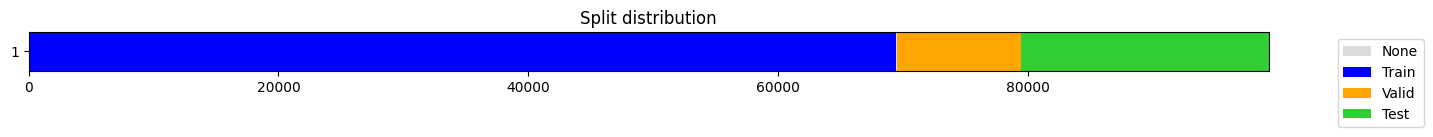

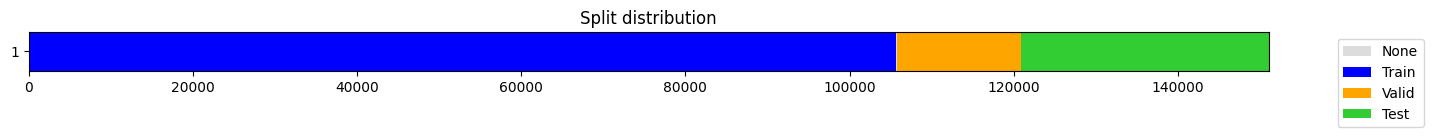

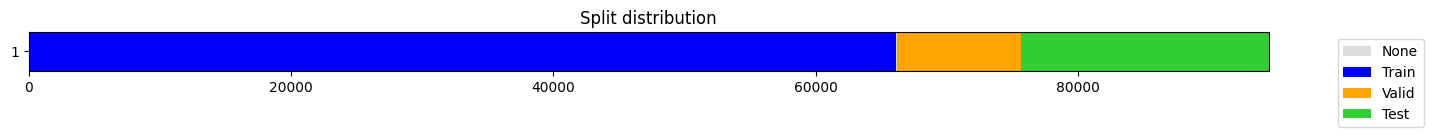

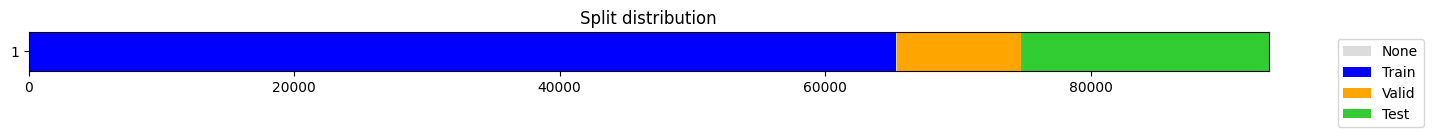

In [18]:
fcst_history = 72 # # steps in the past
fcst_horizon = 12 # # steps in the future

valid_size   = 0.1  # int or float indicating the size of the training set
test_size    = 0.2  # int or float indicating the size of the test set

datetime_col = "date"

splits_jara = get_forecasting_splits(data_jara, fcst_history=fcst_history, fcst_horizon=fcst_horizon, datetime_col=datetime_col, valid_size=valid_size, test_size=test_size)
splits_pena = get_forecasting_splits(data_pena, fcst_history=fcst_history, fcst_horizon=fcst_horizon, datetime_col=datetime_col, valid_size=valid_size, test_size=test_size)
splits_minon = get_forecasting_splits(data_minon, fcst_history=fcst_history, fcst_horizon=fcst_horizon, datetime_col=datetime_col, valid_size=valid_size, test_size=test_size)

splits_all = get_forecasting_splits(data_all, fcst_history=fcst_history, fcst_horizon=fcst_horizon, datetime_col=datetime_col, valid_size=valid_size, test_size=test_size)

In [19]:
x_vars_pena = data_pena.columns[1:]
y_vars_pena = data_pena.columns[1:]

x_vars_jara = data_jara.columns[1:]
y_vars_jara = data_jara.columns[1:]

x_vars_minon = data_minon.columns[1:]
y_vars_minon = data_minon.columns[1:]

x_vars_all = combined_df.columns[1:]
y_vars_all = combined_df.columns[1:]

X_jara, y_jara = prepare_forecasting_data(data_jara, fcst_history=fcst_history, fcst_horizon=fcst_horizon, x_vars=x_vars_jara, y_vars=y_vars_jara)
X_pena, y_pena = prepare_forecasting_data(data_pena, fcst_history=fcst_history, fcst_horizon=fcst_horizon, x_vars=x_vars_pena, y_vars=y_vars_pena)
X_minon, y_minon = prepare_forecasting_data(data_minon, fcst_history=fcst_history, fcst_horizon=fcst_horizon, x_vars=x_vars_minon, y_vars=y_vars_minon)

X_all, y_all = prepare_forecasting_data(combined_df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, x_vars=x_vars_all, y_vars=y_vars_all)

Pruebas:
- Aumentando la ventana de contexto de 24h a 72h los resultados mejoran
- El modelo grande (16 cabezas, dimesión 128, dimensión FC 256) funciona peor con datos de una localización que el modelo pequeño (4 cabezas, dimesión 32, dimensión FC 128), debido a que produce overfitting. En cambio, para la tarea de predecir los 3 conjuntos a la vez, funciona ligeramente mejor el modelo grande.
- Diversas pruebas variando el tamaño de los parches y los strides.

epoch,train_loss,valid_loss,mse,mae,time
0,0.416793,0.391361,0.391361,0.447399,00:26
1,0.446253,0.421622,0.421622,0.467487,00:26
2,0.431960,0.393392,0.393392,0.451617,00:25
3,0.421818,0.384245,0.384245,0.442155,00:26
4,0.438167,0.382020,0.382020,0.441804,00:25
5,0.407944,0.380656,0.380656,0.436831,00:24
6,0.389754,0.378911,0.378911,0.437164,00:24
7,0.405116,0.376377,0.376377,0.436089,00:26
8,0.396542,0.376139,0.376139,0.434945,00:26
9,0.406162,0.373119,0.373119,0.433389,00:26


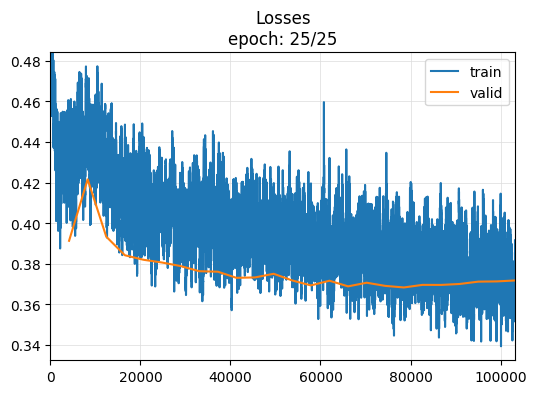

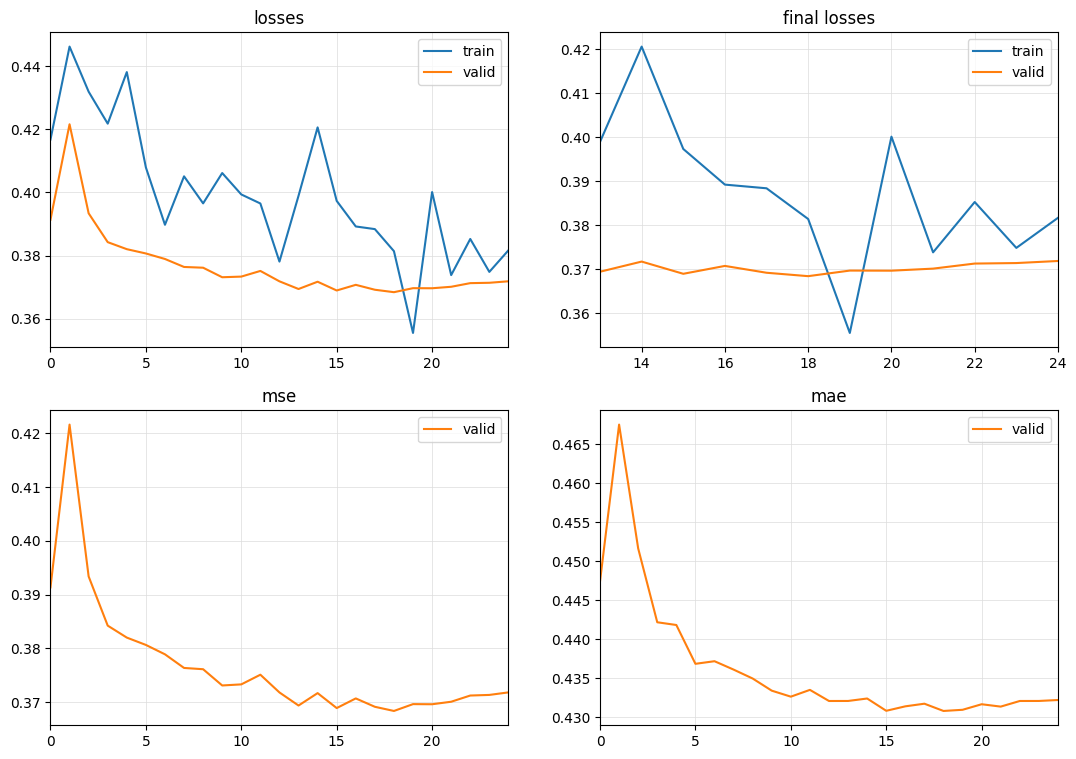

In [38]:

arch_config = dict(
    n_layers=3,  # number of encoder layers
    n_heads=4,  # number of heads (4/16)
    d_model=64,  # dimension of model (32/128)
    d_ff=128,  # dimension of fully connected network (128/256)
    attn_dropout=0, # dropout applied to the attention weights
    dropout=0.2,  # dropout applied to all linear layers in the encoder except q,k&v projections
    patch_len=2,  # length of the patch applied to the time series to create patches
    stride=1,  # stride used when creating patches
    padding_patch=True,  # padding_patch
)

learn = TSForecaster(X_minon, y_minon, splits=splits_minon, batch_size=16, path="models", arch="PatchTST", arch_config=arch_config, metrics=[mse, mae], cbs=ShowGraph())

n_epochs = 25
lr_max = 0.001
learn.fit_one_cycle(n_epochs, lr_max=lr_max)
learn.export('patchTST_72_12_minon.pt')

Error en test

In [30]:
def test_forecaster(learn, X, y, splits):
    y_preds, *_ = learn.get_X_preds(X[splits[2]])
    y_preds = to_np(y_preds)
    y_true = y[splits[2]]
    mse_score = mean_squared_error(y_true.flatten(), y_preds.flatten())
    mae_score = mean_absolute_error(y_true.flatten(), y_preds.flatten())

    X_test = X[splits[2]]
    y_test = y[splits[2]]
    plot_forecast(X_test, y_test, y_preds, sel_vars=True)

    return mse_score, mae_score

All together

In [ ]:
learn = load_learner('models/patchTST_72_12_all.pt')

mse_score, mae_score = test_forecaster(learn, X_all, y_all, splits_all)

print("MSE: ", mse_score)
print("MAE: ", mae_score)

Jara

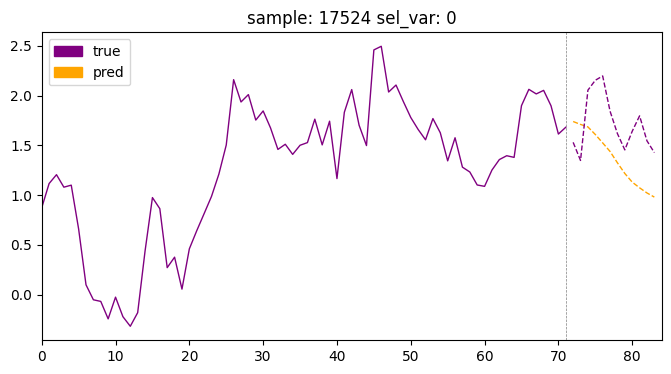

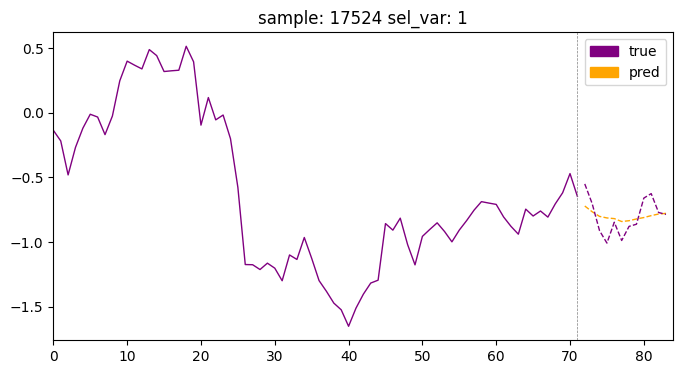

MSE:  0.3210632001893965
MAE:  0.41700508090497984


In [34]:
learn = load_learner('models/patchTST_72_12_jara.pt')

mse_score, mae_score = test_forecaster(learn, X_jara, y_jara, splits_jara)

print("MSE: ", mse_score)
print("MAE: ", mae_score)

Peñaparda

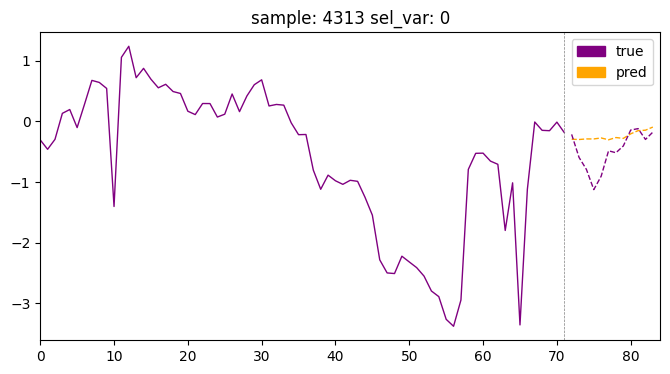

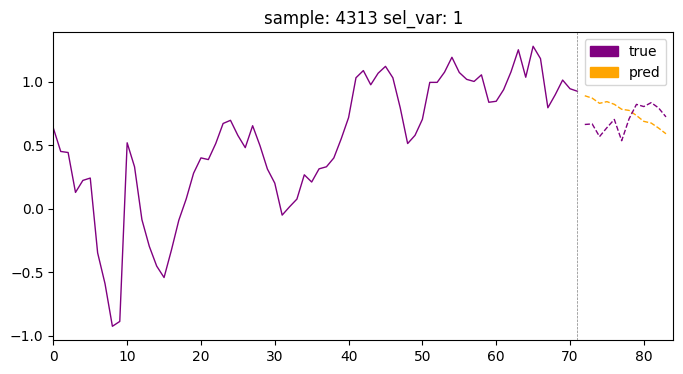

MSE:  0.5207466789510615
MAE:  0.49945728484483726


In [37]:
learn = load_learner('models/patchTST_72_12_pena.pt')

mse_score, mae_score = test_forecaster(learn, X_pena, y_pena, splits_pena)

print("MSE: ", mse_score)
print("MAE: ", mae_score)

Miñón

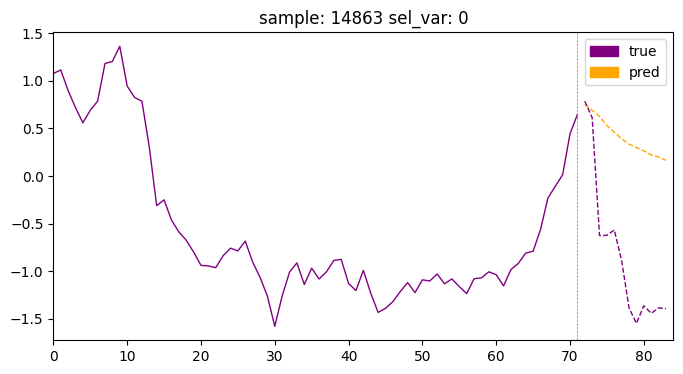

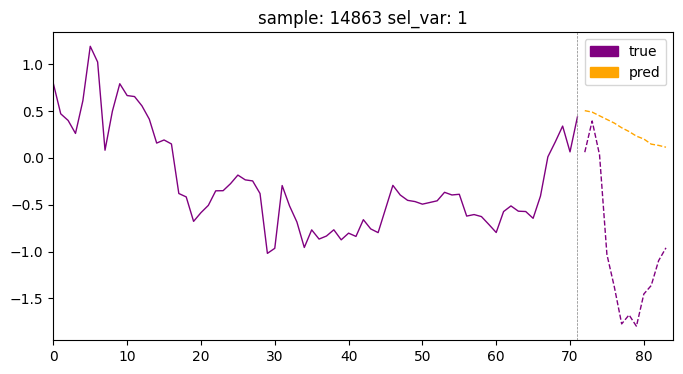

MSE:  0.3703368837454859
MAE:  0.4361471182203373


In [39]:
learn = load_learner('models/patchTST_72_12_minon.pt')

mse_score, mae_score = test_forecaster(learn, X_minon, y_minon, splits_minon)

print("MSE: ", mse_score)
print("MAE: ", mae_score)